# Spatial signature analysis

This experimental notebook explores an inventory of landscapes accross Switzerland, with the aim of characterizing them by means of their spatial signatures - namely a numerical embedding describing a landscape pattern. Examples of spatial signatures include a vector with the proportion of landscape occupied by each class, co-occurrence matrices reflecting pairwise adjacencies between classes or to vector of computed landscape metrics - see the [motif R package](https://github.com/Nowosad/motif) and its journal article [1] for more details on spatial signatures.

Given a set of landscapes, their spatial signatures can be used to perform operations such as spatial pattern search, change detection or clustering (see Nowosad [1] for more details). In this example, spatial signatures are used to cluster landscapes and obtain a typology of Swiss landscapes. The cells of the data processing section serve to generate an inventory of local landscapes accross Switzerland. The landscape inventory is used to showcase how the `SpatialSignatureAnalysis` class can be used to explore the fundamental components of landscape metrics as well as to cluster landscapes. Finally, the landscape inventory is clustered using two types of spatial signatures, namely (a) a vector of ten recurrent landscape metrics and (b) an information theory (IT) approach based on Nowosad and Stepinski [2].

First of all, in order to run this notebook, we need to install the version of pylandstats that currently lives in the "feat-spatial-signature" branch of the GitHub repository. It is recommended to first install GDAL (or directly geopandas) using conda/mamba, and then install the experimental pylandstats version using pip as in:

```
pip install https://github.com/martibosch/pylandstats/archive/feat-spatial-signature.zip
```

We will continue with some imports, definitions and data processing. If you are mainly interested in the features of `SpatialSignatureAnalysis`, feel free to skip to ["2. Spatial signature analysis"](#spatial-signature-analysis) section. 

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import seaborn as sns
import swisslandstats as sls
from rasterio import features
from shapely import geometry
from sklearn import decomposition

import pylandstats as pls

# set parameters which are not related to the cluster analysis itself (e.g., plotting)
# random seed to ensure repeatability of this notebook
random_seed = 0
# TODO: use random.PCG64 - see https://github.com/scikit-learn/scikit-learn/issues/16988
# bg = random.RandomState(random_seed)

# plotting parameters
figwidth, figheight = plt.rcParams["figure.figsize"]

heatmap_kwargs = dict(annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)

# parameters for the cluster landscape plots
plot_cluster_landscapes_kwargs = dict(
    figwidth=3,
    figheight=3,
    sample_kwargs=dict(random_state=random_seed),
    subfigures_kwargs=dict(hspace=0.05),
    supylabel_kwargs=dict(x=0.1),
    cmap=sls.noas04_4_cmap,
    norm=sls.noas04_4_norm,
)


def plot_cgram_eval(cgram, *, eval_methods=None):
    """Plot clustergram evaluation methods."""
    if eval_methods is None:
        eval_methods = [
            "silhouette_score",
            "calinski_harabasz_score",
            "davies_bouldin_score",
        ]
    n_plots = len(eval_methods)
    fig, axes = plt.subplots(n_plots, 1, figsize=(figwidth, figheight * n_plots))
    for eval_method, ax in zip(eval_methods, axes):
        getattr(cgram, eval_method)().plot(ax=ax)
        ax.set_ylabel(eval_method)

    ax.set_xlabel("n. clusters")

    return fig

## 1. Data preprocessing

We first need to run the cell below so that the land use/land cover (LULC) data is downloaded and preprocessed (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details).

In [ ]:
!snakemake -c1 -d .. -s ../Snakefile switzerland_lulc_tifs

Assuming unrestricted shared filesystem usage.
host: pop-os
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


We will set the main parameters of the cluster analysis in the cell below:

In [ ]:
lulc_col = "LU18_4"
input_filepath = f"../data/processed/switzerland/{lulc_col}.tif"

# Size (in meters) of each landscape, i.e., each landscape is a tile of 10000x10000 m^2,
# i.e., 10x10 km^2
landscape_size = 10000

Let us start by generating the landscapes for the spatial signature analysis by generating a `ZonalGridAnalysis` with the target grid size. However, in order to enhance landscape comparability, we will exclude the grid cells at the border of our raster extent so that we only have squared landscapes full of valid data pixels:

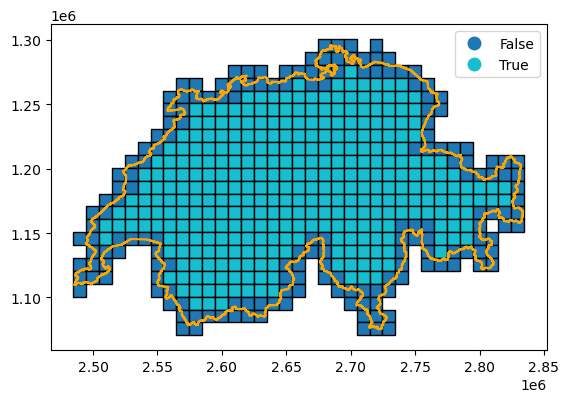

In [ ]:
zga = pls.ZonalGridAnalysis(
    input_filepath,
    zone_width=landscape_size,
    zone_height=landscape_size,
    offset="center",
)
with rio.open(input_filepath) as src:
    extent_geom = gpd.GeoSeries(
        [
            geometry.shape(geom)
            for geom, val in features.shapes(
                src.dataset_mask(), transform=src.transform
            )
            if val != src.nodata
        ],
        crs=src.crs,
    ).union_all()

is_inner = zga.zone_gser.within(extent_geom)
ax = gpd.GeoDataFrame({"is_inner": is_inner}, geometry=zga.zone_gser).plot(
    column="is_inner", edgecolor="black", legend=True
)
for geom in extent_geom.geoms:
    ax.plot(*geom.exterior.xy, color="orange")

Let us now use the filtered geo-series of grid cells to instantiate a `ZonalAnalysis` with only the landscapes that are fully contained by the raster extent (i.e., the Swiss border):

In [ ]:
za = pls.ZonalAnalysis(input_filepath, zga.zone_gser[is_inner].copy())

Here is what one of this landscapes looks like (legend: red pixels are urban, green pixels are agricultural, yellow pixels are wooded areas and blue pixels are unproductive areas, e.g., lakes, rivers, glaciers...):

<Axes: >

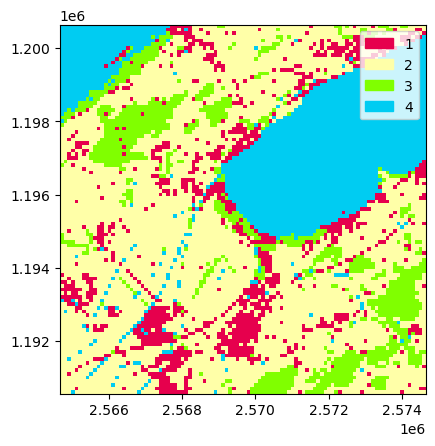

In [ ]:
za.landscape_ser.sample(1, random_state=random_seed).iloc[0].plot_landscape(
    cmap=sls.noas04_4_cmap, norm=sls.noas04_4_norm, legend=True
)

<a id='spatial-signature-analysis'></a>
## Spatial signature analysis

We can now use the generated `ZonalAnalysis` instantiate the `SpatialSignatureAnalysis` class. In fact, we could also use any other pylandstats multi-landscape class (e.g., `SpatioTemporalAnalysis`, `SpatioTemporalZonalAnalysis`, `ZonalGridAnalysis`...). However, unlike the other pylandstats multi-landscape classes, in a `SpatialSignatureAnalysis` the metrics are computed when the object is instantiated. Therefore, the initialization requires the list of target metrics both for the class and landscape level:

In [ ]:
ssa = pls.SpatialSignatureAnalysis(
    za,
    class_metrics=[
        "proportion_of_landscape",
        "edge_density",
    ],
    landscape_metrics=[
        "shannon_diversity_index",
    ],
)

[########################################] | 100% Completed | 2.23 sms
[########################################] | 100% Completed | 1.50 sms


The computed metrics for each landscape can be accessed via the `metrics_df` attribute, which is definitive and thus cannot be changed after the instantiation:

In [ ]:
ssa.metrics_df.head()

,proportion_of_landscape_1,proportion_of_landscape_2,proportion_of_landscape_3,proportion_of_landscape_4,edge_density_1,edge_density_2,edge_density_3,edge_density_4,shannon_diversity_index
grid_cell,,,,,,,,,
91,8.287129,59.702970,28.970297,3.039604,21.772277,44.960396,25.435644,7.752475,0.979163
122,15.099010,40.742574,40.762376,3.396040,25.821782,39.435644,26.693069,6.207921,1.131916
125,15.514851,47.188119,35.277228,2.019802,27.465347,45.257426,26.950495,6.029703,1.089952
126,27.128713,48.247525,23.485149,1.138614,29.663366,40.861386,19.900990,4.009901,1.096330
127,20.564356,54.237624,23.554455,1.643564,32.178218,48.435644,25.108911,4.950495,1.063955


As shown above, it is possible to include both metrics at the class and landscape level in the spatial signature by providing both the `class_metrics` and `landscape_metrics` arguments. Instead of using a multi-level index with the landscape id and class value (like in the other pylandstats multi-landscape classes), the class values are ["pivoted"](https://pandas.pydata.org/docs/user_guide/reshaping.html) into the columns so that each row is a vector of metrics, i.e., the spatial signature of the landscape.

Therefore, the resulting data frame consists of a single row unique to each landscape, which features all the computed metrics (at the class and landscape-level) as columns, i.e., the spatial signature of the landscape.

Likewise the other pylandstats multi-landscape classes, we can use the `classes` argument compute the metrics for a subset of classes only. Similarly, it is possible to customize how the metrics are computed, however, in `SpatialSignatureAnalysis.compute_metrics_df` this is done by means of two arguments `class_metrics_kwargs` and `landscape_metrics_kwargs`, which customize the computation of the class and landscape-level metrics, respectively.

In [ ]:
ssa = pls.SpatialSignatureAnalysis(
    za,
    class_metrics=[
        "proportion_of_landscape",
    ],
    classes=[1, 2],
    class_metrics_kwargs={"proportion_of_landscape": {"percent": False}},
    landscape_metrics=[
        "edge_density",
        "shannon_diversity_index",
    ],
    landscape_metrics_kwargs={
        "edge_density": {"count_boundary": True},
    },
)
ssa.metrics_df.head()

[########################################] | 100% Completed | 740.43 ms
[########################################] | 100% Completed | 1.00 sms


,proportion_of_landscape_1,proportion_of_landscape_2,edge_density,shannon_diversity_index
grid_cell,,,,
91,0.082871,0.597030,53.940594,0.979163
122,0.150990,0.407426,53.059406,1.131916
125,0.155149,0.471881,56.831683,1.089952
126,0.271287,0.482475,51.198020,1.096330
127,0.205644,0.542376,59.316832,1.063955


Further details about the arguments of the `SpatialSignatureAnalysis` initialization can be found in the [API documentation](https://pylandstats.readthedocs.io/en/latest/spatial-signatures.html).

Let us now focus on the (many) potential applications of the spatial signature analysis. From a data science perspective, the `metrics_df` constitutes a dataset matrix in which each row is a sample (i.e., a landscape) that is in turn represented by a feature vector (i.e., a metric). This dataset matrix can be used for a wide range of computational landscape ecology applications, such as clustering similar landscapes or identifying the main components of spatial patterns [3]. In Python, the [scikit-learn library](https://scikit-learn.org/stable/index.html) [4] provides a wide range of tools for data science and machine learning that can be used for these purposes.

The sections below show how the `SpatialSignatureAnalysis` provides a convenient interface to use scikit-learn tools for clustering and component analysis of spatial patterns. Let us start by instantiating a `SpatialSignatureAnalysis` with the generated landscapes and a set of ten metrics (at the landscape level only) chosen loosely following the work of Nowosad and Stepinski [5] (the list of metrics is actually adapted considering the metrics that are currently implemented in pylandstats):

In [ ]:
ten_metrics = [
    # area and edge
    "area_mn",
    "perimeter_mn",
    "patch_density",
    "edge_density",
    # shape
    "fractal_dimension_am",
    "shape_index_mn",
    # aggregation
    "contagion",
    "effective_mesh_size",
    "landscape_shape_index",
    # diversity
    "shannon_diversity_index",
]
ten_ssa = pls.SpatialSignatureAnalysis(
    za,
    landscape_metrics=ten_metrics,
)
ten_ssa.metrics_df.head()

[########################################] | 100% Completed | 13.90 s


,area_mn,perimeter_mn,patch_density,edge_density,fractal_dimension_am,shape_index_mn,contagion,effective_mesh_size,landscape_shape_index,shannon_diversity_index
grid_cell,,,,,,,,,,
91,19.092628,1983.742911,5.237624,49.960396,1.224389,1.183515,39.382767,3628.051683,13.552239,0.979163
122,22.494432,2297.550111,4.445545,49.079208,1.175753,1.252719,32.406410,717.249307,13.330846,1.131916
125,19.201521,2106.083650,5.207921,52.851485,1.197667,1.215890,33.345581,1414.022178,14.278607,1.089952
126,22.100656,2175.054705,4.524752,47.217822,1.208605,1.190722,34.890328,2491.811683,12.863184,1.096330
127,18.067979,2071.556351,5.534653,55.336634,1.217015,1.204576,33.582820,2278.386535,14.902985,1.063955


## Component analysis

As extensively reviewed in the literature, landscape metrics are highly correlated, which can be problematic for many applications, e.g., multicolinearity can undermine statistical inference when establishing  relationships between spatial pattern and ecological responses. Since `metrics_df` is a pandas data frame, we can easily compute the correlation matrix of the metrics and plot it as a heat map:

<Axes: >

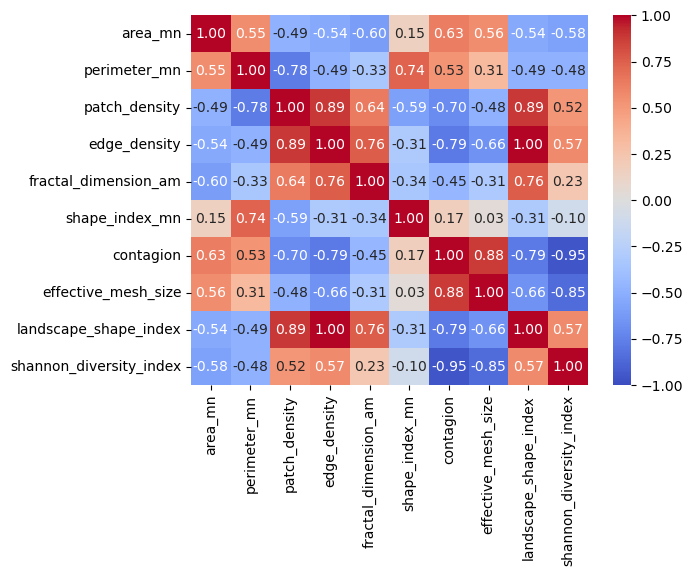

In [ ]:
sns.heatmap(ten_ssa.metrics_df.corr(), **heatmap_kwargs)

The heatmap shows that many metrics are almost perfectly correlated, either positively (e.g., edge density and landscape shape index) or negatively (e.g., contagion and Shannon diversity index).

One way to address this issue is to factorize the metrics data frame into a reduced set of components that explain the most variance in the data. To that end, the scikit-learn library [features many classes implementing different decomposition algorithms](https://scikit-learn.org/stable/modules/decomposition.html#decompositions). Let us use the [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) algorithm:

In [ ]:
# provide `random_state` for reproducibility
component_df, decompose_model = ten_ssa.decompose(
    decomposer=decomposition.PCA, random_state=random_seed
)
component_df.head()

,0,1,2,3,4,5,6,7,8,9
grid_cell,,,,,,,,,,
91,0.675821,-2.032377,-0.532707,-0.260041,-0.029602,0.174420,0.072500,0.044971,-0.020892,-2.366422e-15
122,0.570350,0.823715,-1.330614,0.381037,-0.083500,-0.781481,0.073059,0.043649,-0.050512,-4.476341e-15
125,1.250683,-0.389326,-1.012317,0.346173,-0.076389,-0.563351,0.067174,0.108255,-0.026578,-2.848671e-15
126,0.566262,-0.874137,-1.106217,-0.086841,-0.586429,0.148765,0.180104,0.007162,-0.059424,-6.100160e-15
127,1.514240,-1.047658,-0.507952,0.240376,0.017438,-0.150777,0.095958,0.097840,-0.034021,-3.079043e-15


The `decompose` method returns both (i) a data frame with the components as columns and the landscapes as rows and (ii) the decomposition model. While the data frame alone may be hard to interpret, it can be used in conjunction with the decomposition model to obtain very useful information, such as the explained variance of each component and the loadings of each metric on each component.

We can access the explained variance of each component by using the `explained_variance_ratio_` attribute of the decomposition model:

In [ ]:
decompose_model.explained_variance_ratio_

array([6.18151788e-01, 1.64046695e-01, 1.05041010e-01, 6.67206943e-02,
       2.60517062e-02, 1.44168164e-02, 3.72856346e-03, 1.61737746e-03,
       2.25349012e-04, 9.51197918e-18])

As we can see, the four first components respectively explain a 61.18, 16.40, 10.50 and 6.67 % of the total variance (making it a total of 95.40 %). This information can be used to decide how many components to retain in the analysis.

We can also access the loadings of each metric on each component by using the `get_loading_df` method:

In [ ]:
loading_df = ten_ssa.get_loading_df(decompose_model)
loading_df

,0,1,2,3,4,5,6,7,8,9
area_mn,-0.290885,-0.094671,0.012901,0.818267,-0.087067,0.221251,-0.403344,-0.121032,0.053170,5.931240e-15
perimeter_mn,-0.281758,0.360654,0.467496,0.173914,-0.358581,0.090579,0.483745,0.410525,-0.049167,-6.649970e-15
patch_density,0.359779,-0.262514,0.022367,0.236894,0.386189,-0.051016,-0.050911,0.766701,0.053479,3.682994e-15
edge_density,0.370413,-0.019812,0.311976,0.240083,0.125083,-0.130791,0.245558,-0.325653,0.091286,-7.071068e-01
fractal_dimension_am,0.280664,-0.196856,0.562714,-0.297688,-0.344568,0.357591,-0.473574,0.037463,0.070263,7.227927e-15
shape_index_mn,-0.172664,0.606443,0.315193,-0.108746,0.606061,-0.001228,-0.345135,-0.019840,0.066476,7.121826e-15
contagion,-0.364325,-0.278554,0.151092,-0.112448,-0.007125,-0.356937,0.005569,0.030954,0.791049,6.682840e-14
effective_mesh_size,-0.307486,-0.412645,0.130690,-0.120496,0.436916,0.612571,0.348857,-0.116483,-0.046571,-4.552947e-15
landscape_shape_index,0.370413,-0.019812,0.311976,0.240083,0.125083,-0.130791,0.245558,-0.325653,0.091286,7.071068e-01
shannon_diversity_index,0.310292,0.369965,-0.360862,0.034452,-0.080135,0.524889,0.122444,0.023821,0.581332,4.881344e-14


Given the explained variance, we can focus on the first four components and visualize this information using a heatmap:

<Axes: >

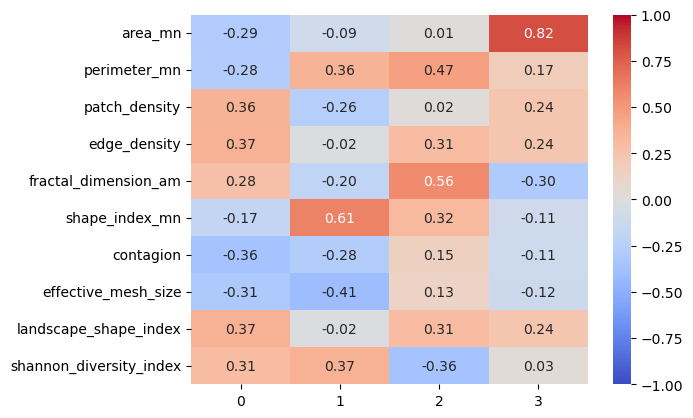

In [ ]:
# ten_ssa.plot_loading_heatmap(decompose_model)
n_components = 4
sns.heatmap(loading_df.iloc[:, :n_components], **heatmap_kwargs)

As we can see, the first component is positively correlated with edge density and landscape shape index and negatively correlated with contagion, which suggest that this component is negatively related to the aggregation of patches. The second, third and fourth components are positively correlated with the mean shape index, area-weighted mean fractal dimension and mean patch area metrics.

In short, the component analysis can help identifying the fundamental components of spatial patterns and their relationships with the landscape metrics. This can help us in choosing the most relevant metrics for a given application and avoid multicolinearity issues.

## Clustering landscapes based on spatial signatures

Another common application of the spatial signature analysis is to cluster similar landscapes based on their spatial patterns. To assist in this task, the `SpatialSignatureAnalysis` class provides a `get_cgram` method that computes a clustergram [6] based on the spatial signagures. The returned object is a [`Clustergram`](https://clustergram.readthedocs.io/en/stable/api.html#clustergram.clustergram.Clustergram) [7] instance that can be used to visualize clustergram diagrams and select the number of clusters:

K=2 fitted in 0.153 seconds.
K=3 fitted in 0.007 seconds.
K=4 fitted in 0.005 seconds.
K=5 fitted in 0.005 seconds.
K=6 fitted in 0.006 seconds.
K=7 fitted in 0.006 seconds.
K=8 fitted in 0.007 seconds.
K=9 fitted in 0.007 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

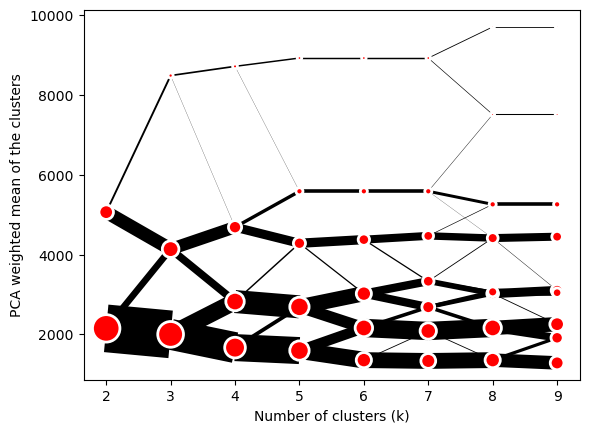

In [ ]:
# provide `random_state` for reproducibility
ten_cgram = ten_ssa.get_cgram(k_range=range(2, 10), random_state=random_seed)
ten_cgram.plot()

As we can see, setting the number of clusters to 3 seems a good choice. Alternatively, we can use the `silhouette_score`, `calinski_harabasz_score` and `davies_bouldin_score` methods of the returned `cgram` to evaluate the quality of the clustering for different numbers of clusters:

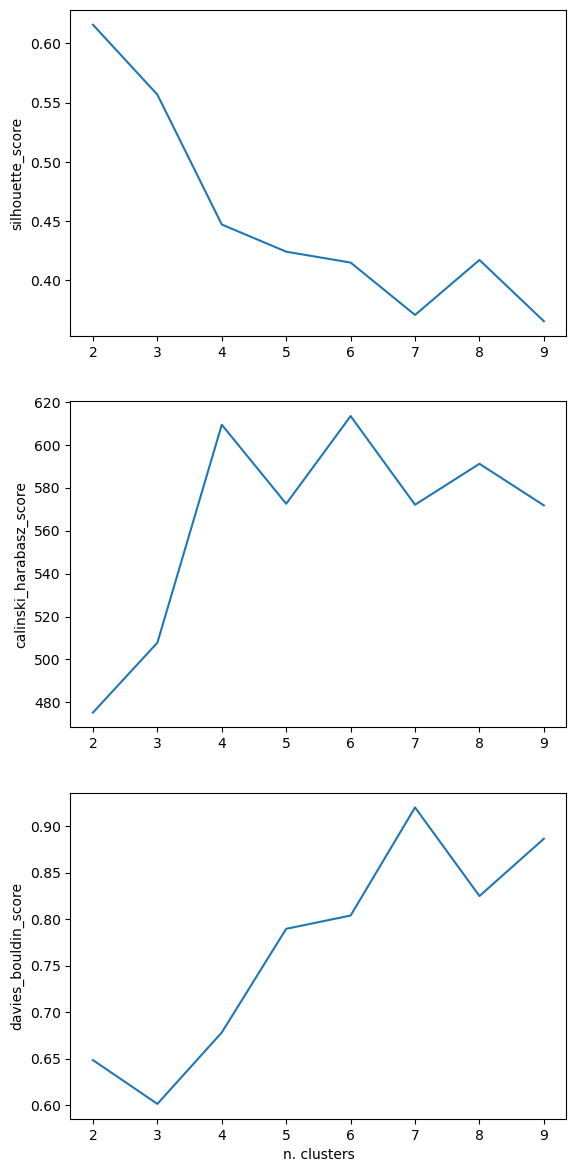

In [ ]:
_ = plot_cgram_eval(ten_cgram)

Ideally, we want to pick the number of clusters that maximizes the `silhouette_score` and `calinski_harabasz_score` and minimizes the `davies_bouldin_score`, which in this case is in line with the clustergram diagram, i.e., 3 clusters.

Given the number of clusters, we can access the labels of the landscapes in each cluster by using the `labels_` attribute of the `cgram` object:

In [ ]:
n_clusters = 3
ten_cgram.labels_[n_clusters]

0      2
1      0
2      0
3      0
4      0
      ..
324    2
325    2
326    0
327    2
328    1
Name: 3, Length: 329, dtype: int32

We can also use `scatterplot_cluster_metrics` method of `SpatialSignatureAnalysis` to obtain a scatterplot of any given pair of metrics, with the landscapes colored by their cluster labels. Based on the metrics correlations and PCA loadings, we can choose the contagion, mean shape index, area-weighted mean fractal dimension and mean area metrics to visualize the clusters:

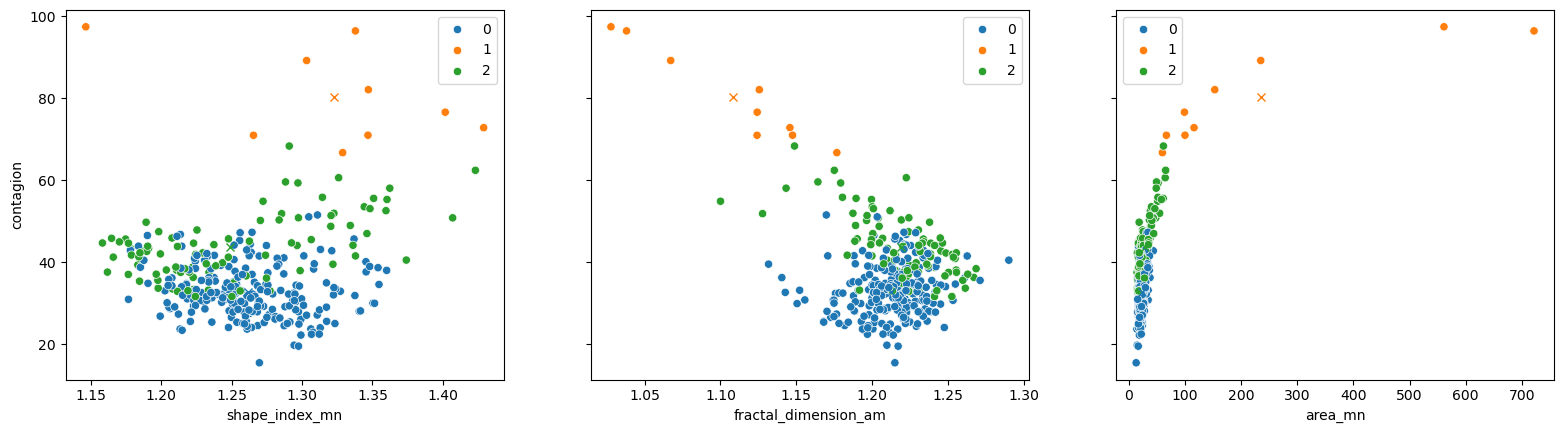

In [ ]:
other_metrics = ["shape_index_mn", "fractal_dimension_am", "area_mn"]
fig, axes = plt.subplots(
    1,
    len(other_metrics),
    figsize=(len(other_metrics) * figwidth, figheight),
    sharey=True,
)
for other_metric, ax in zip(other_metrics, axes):
    ten_ssa.scatterplot_cluster_metrics(
        ten_cgram, n_clusters, other_metric, "contagion", ax=ax
    )

As we can see, the clusters can be largely separated by means of the contagion index only, with cluster "0" having low values, cluster "2" having mid-range values and cluster "1" having high values of both contagion and mean patch area. *Note that the colored "x" markers correspond to the centroids of their respective clusters.*

To get a better grasp of the clustering results, we can use the `plot_cluster_landscapes` method to visualize the landscapes in each cluster:

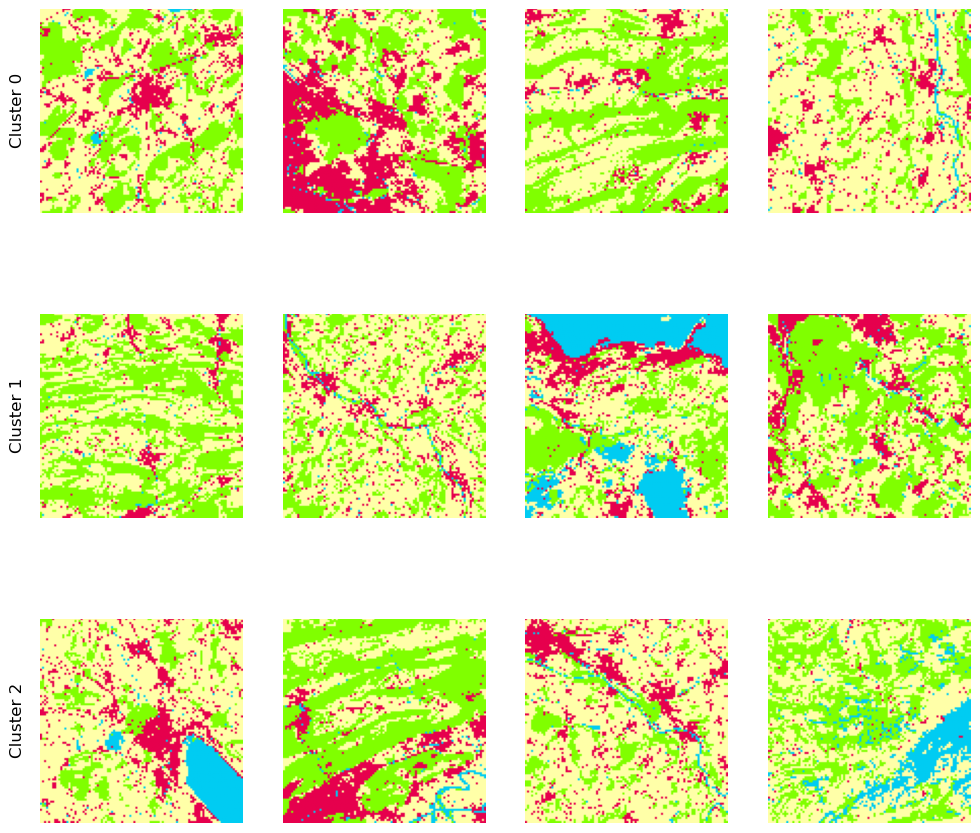

In [ ]:
ten_fig = ten_ssa.plot_cluster_landscapes(
    ten_cgram, n_clusters, **plot_cluster_landscapes_kwargs
)

Finally, we can use the `plot_cluster_zones` method to visualize the landscape extents colored by their cluster labels:

<Axes: >

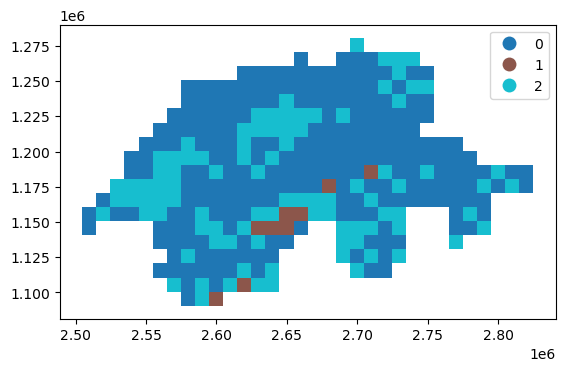

In [ ]:
ten_ssa.plot_cluster_zones(ten_cgram, n_clusters)

*Note that we can only call `plot_cluster_zones` if the `SpatialSignatureAnalysis` instance has been initialized with a zonal analysis class (i.e., `ZonalAnalysis`, `BufferAnalysis`, `ZonalGridAnalysis` and their corresponding spatio-temporal analsysis classes).*

## Fundamental components of landscape patterns: further insights from information theory (IT)

The above sections illustrate how the `SpatialSignatureAnalysis` class operates with some example real-world applications. Let us now take this one step further and address a key question of spatial pattern analysis in landscape ecology (see the "Spatial patterns" section of the review of Hesselbarth et al. [3] for more details): *what are the fundamental components of landscape configuration?*

Following the approach of Nowosad and Stepinski [2], we will now try to use an information theory (IT)-based approach to classify landscapes, i.e., the HYU diagram, where H and U respectively refer to [the Shannon's entropy](https://pylandstats.readthedocs.io/en/latest/landscape.html#pylandstats.Landscape.entropy) and [the relative mutual information criterion](https://pylandstats.readthedocs.io/en/latest/landscape.html#pylandstats.Landscape.relative_mutual_information) (see Nowosad and Stepinski [2] for more details).

To perform this IT-based analsyis, let us instantiate another `SpatialSignatureAnalysis` using these two metrics (which can only be computed at the landscape level):

In [ ]:
it_metrics = ["entropy", "relative_mutual_information"]
it_ssa = pls.SpatialSignatureAnalysis(za, landscape_metrics=it_metrics)

[########################################] | 100% Completed | 3.90 ss


Note that since we are only using two landscape metrics, we can skip the factorization into components (e.g., PCA) and proceed directly to the cluster analysis.

K=2 fitted in 0.004 seconds.
K=3 fitted in 0.003 seconds.
K=4 fitted in 0.003 seconds.
K=5 fitted in 0.003 seconds.
K=6 fitted in 0.005 seconds.
K=7 fitted in 0.004 seconds.
K=8 fitted in 0.005 seconds.
K=9 fitted in 0.004 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

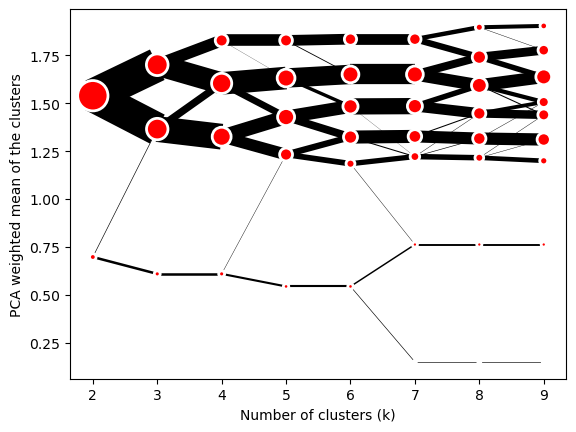

In [ ]:
it_cgram = it_ssa.get_cgram(k_range=range(2, 10), random_state=random_seed)
it_cgram.plot()

Likewise the analysis based on ten landscape metrics, we can complement the clustergram with the other metrics:

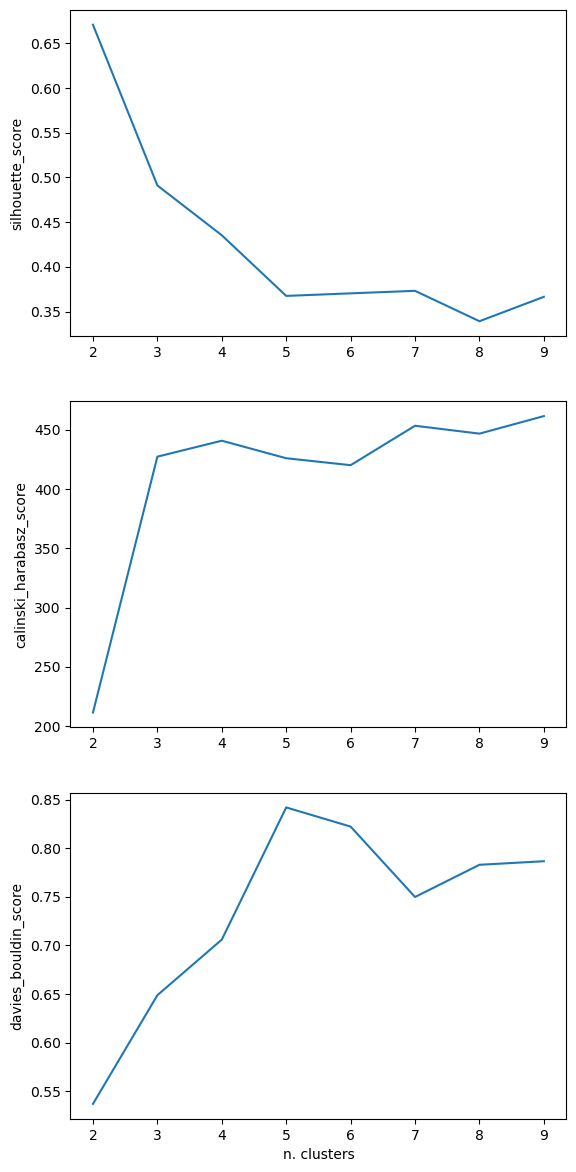

In [ ]:
_ = plot_cgram_eval(it_cgram)

The clustergram and the metrics seemingly agree that using 3 clusters is an appropriate choice. We can again visualize the clusters in a two-dimensional scatter plot of the two metrics:

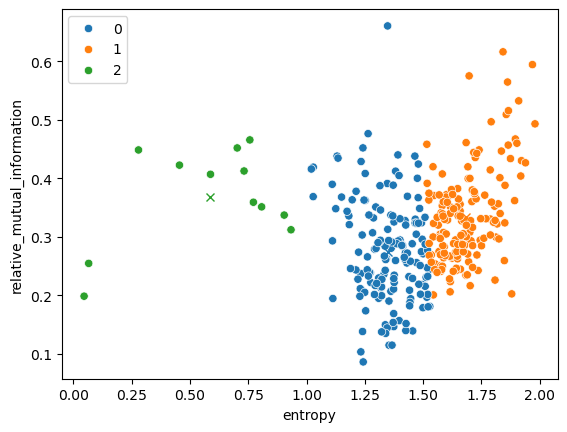

In [ ]:
n_clusters = 3
_ = it_ssa.scatterplot_cluster_metrics(
    it_cgram, n_clusters, "entropy", "relative_mutual_information"
)

It seems that the landscapes can be practically separated using the entropy alone. Let us now visualize the landscapes of each cluster:

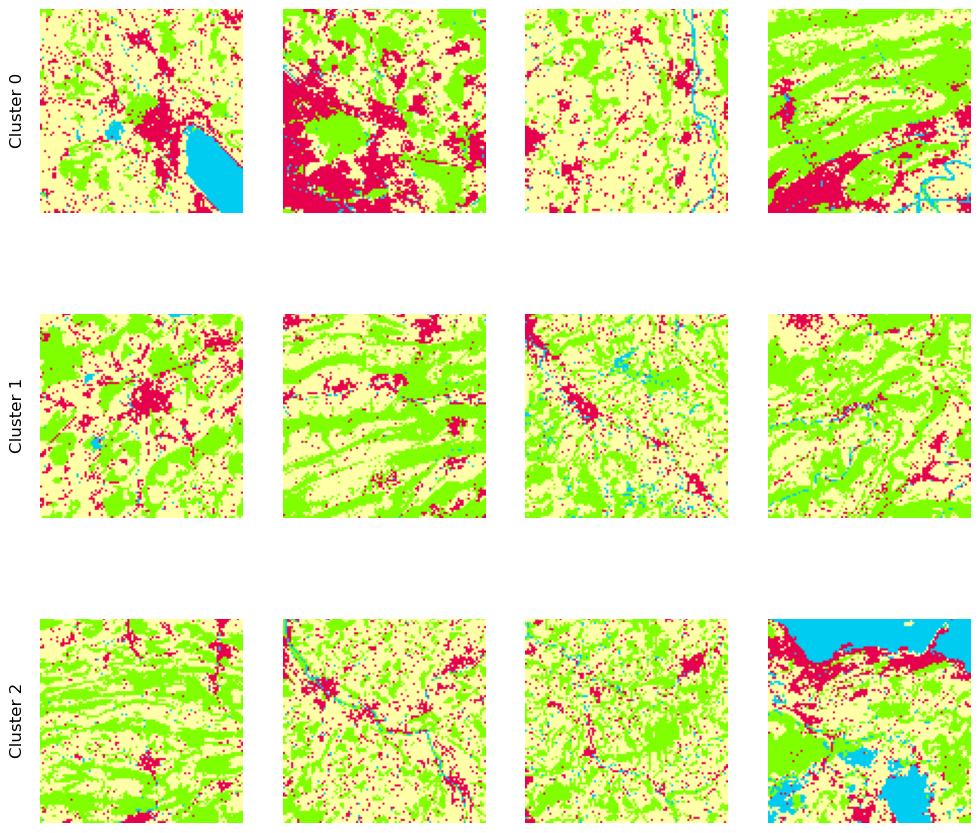

In [ ]:
it_fig = it_ssa.plot_cluster_landscapes(
    it_cgram, n_clusters, **plot_cluster_landscapes_kwargs
)

We can see that the *cluster 1* seems to group the landscapes with most equitable distribution of class abundance (hence the highest entropy values).

To conclude, let us compare the results of the ten metrics-based and the IT-based cluster analyses. We can evaluate the consistency of the ten metrics-based and the IT-based cluster classifications by comparing their respective [silhouette scores](https://en.wikipedia.org/wiki/Silhouette_(clustering)):

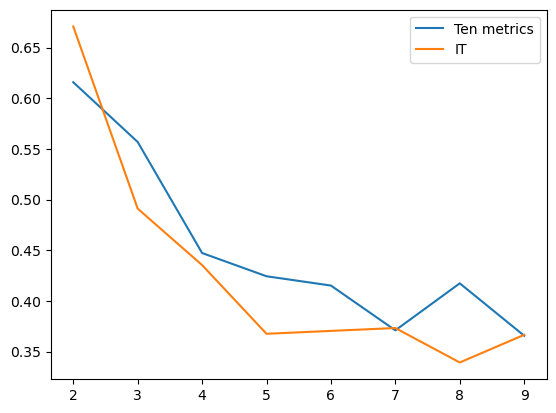

In [ ]:
colors = sns.color_palette()
fig, ax = plt.subplots()
for cgram, label, color in zip([ten_cgram, it_cgram], ["Ten metrics", "IT"], colors):
    cgram.silhouette_score().plot(color=color, ax=ax, label=label)
ax.legend()

Using ten metrics consistently results in higher silhouette scores for the same number of clusters (with only exceptions for 2, 7 and 9 clusters), however the differences are rather small and it is worth noting that using the ten metrics is very likely to result in multi-collinearity issues.

Finally, let us plot the landscape extents colored by their cluster labels on a map:

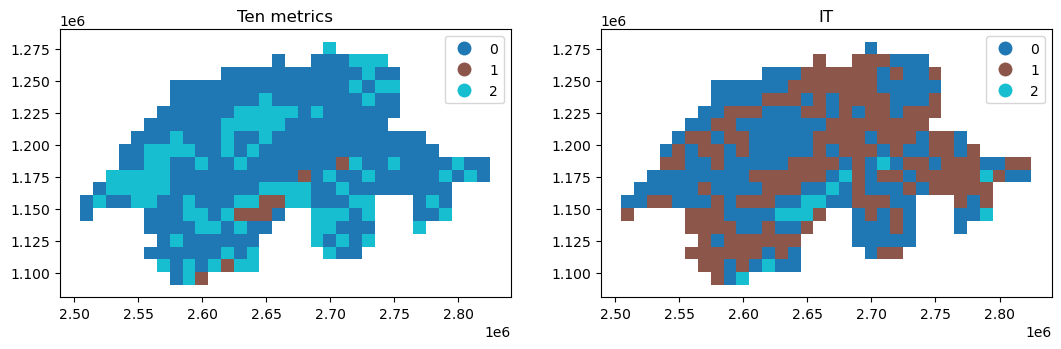

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(figwidth * 2, figheight))
for ssa, cgram, title, ax in zip(
    [ten_ssa, it_ssa], [ten_cgram, it_cgram], ["Ten metrics", "IT"], axes
):
    ssa.plot_cluster_zones(cgram, n_clusters, ax=ax)
    ax.set_title(title)

As we can see, the results are quite similar, especially for *cluster 1* in the ten metrics approach and *cluster 2* in the IT-based approach, which are practically identical and correspond to the landscapes with highest aggregation and lowest entropy (with a more uneven distribution of class abundance).

Even though this is beyond the scope of this notebook, note that we have only included metrics of spatial configuration at the landscape level. Spatial abundance (namely the proportion of landscape metric at each class level) is certainly another fundamental component of spatial pattern, if not the most fundamental one [3, 5, 8-10]. The way in which landscapes are clustered based on entropy alone

## References

1. Nowosad, Jakub. "Motif: an open-source R tool for pattern-based spatial analysis." Landscape Ecology 36 (2021): 29-43.
2. Nowosad, J., & Stepinski, T. F. (2019). Information theory as a consistent framework for quantification and classification of landscape patterns. Landscape Ecology, 34(9), 2091-2101.
3. Hesselbarth, M. H., Nowosad, J., de Flamingh, A., Simpkins, C. E., Jung, M., Gerber, G., & Bosch, M. (2025). Computational Methods in Landscape Ecology. Current Landscape Ecology Reports, 10(1), 1-18.
4. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. the Journal of machine Learning research, 12, 2825-2830.
5. Nowosad, J., & Stepinski, T. F. (2018). Global inventory of landscape patterns and latent variables of landscape spatial configuration. Ecological Indicators, 89, 159-167.
6. Schonlau, M. (2002). The clustergram: A graph for visualizing hierarchical and nonhierarchical cluster analyses. The Stata Journal, 2(4), 391-402.
7. Fleischmann, M. (2023). Clustergram: Visualization and diagnostics for cluster analysis. Journal of Open Source Software, 8(89), 5240.
8. Gustafson, E. J. (1998). Quantifying landscape spatial pattern: what is the state of the art?. Ecosystems, 1(2), 143-156.
9. Gustafson, E. J. (2019). How has the state-of-the-art for quantification of landscape pattern advanced in the twenty-first century?. Landscape Ecology, 34, 2065-2072.
10. Riitters, K. (2019). Pattern metrics for a transdisciplinary landscape ecology. Landscape Ecology, 34(9), 2057-2063.